In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sbpy.calib import Sun
from astropy import units as u
from astropy.io import fits

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from astropy.visualization import ImageNormalize, PercentileInterval, AsinhStretch

from lvmdrp.core.constants import LVM_UNAM_URL
from lvmdrp.utils.examples import fetch_example_data, get_frames_metadata

from lvmdrp.core import rss, image, spectrum1d
from lvmdrp.functions import imageMethod, rssMethod, fluxCalMethod

plt.style.use("seaborn-v0_8-talk")

In [2]:
# define input data directory
data_path = os.path.abspath(os.path.join("..", "data"))

# let's create the output directory
output_path = "./data"
os.makedirs(output_path, exist_ok=True)

# create processed frames path template
out_main_path = os.path.join(output_path, "lvm-{kind}-{camera}-{expnum}.{ext}")
out_calib_path = os.path.join(output_path, "lvm-{mjd}-{kind}-{camera}-{exptime}.{ext}")

In [3]:
# extract metadata
frames_table = get_frames_metadata(path=os.path.join(data_path, "lco_com"), ignore_cache=False)
# group by imagetyp, camera and exptime
frames_table = frames_table.group_by(["mjd", "imagetyp", "spec", "camera", "expnum", "exptime"])
# define groups and unique categories in those groups
frames_groups = frames_table.groups
unique_groups = frames_groups.keys

[INFO]: loading cached metadata from '/home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/frames_table.pkl'


In [4]:
import itertools as it


mjds = np.unique(unique_groups["mjd"])
cameras = ["b", "r", "z"]
spec = 1
for mjd, camera in it.product(mjds, cameras):
    biases = frames_groups[(unique_groups["mjd"]==mjd)&(unique_groups["imagetyp"]=="bias")&(unique_groups["spec"]==f"sp{spec}")&(unique_groups["camera"]==f"{camera}{spec}")]
    biases.pprint(max_width=200)
    
    # let's pre-process the all bias frames
    pbias_paths = []
    for bias_frame in biases:
        bias_path = bias_frame["path"]
        bias_camera, bias_expnum = bias_frame["camera"], bias_frame["expnum"]

        pbias_path = out_main_path.format(kind="pbias", camera=bias_camera, expnum=bias_expnum, ext="fits")

        imageMethod.preprocRawFrame_drp(
            in_image=bias_path,
            out_image=pbias_path,
            subtract_overscan=True, unit="electron", compute_error=True,
            os_bound_y="1,4080", os_bound_x="2044,2077"
        )
        pbias_paths.append(pbias_path)

    imageMethod.createMasterFrame_drp(
        in_images=pbias_paths,
        out_image=out_calib_path.format(mjd=mjd, kind="mbias", camera=bias_camera, exptime=int(bias_frame["exptime"]), ext="fits"),
    )

imagetyp spec  mjd  camera  expnum  exptime                                                                   path                                                                 
-------- ---- ----- ------ -------- ------- ---------------------------------------------------------------------------------------------------------------------------------------
    bias  sp1 60009     b1 00000025     0.0 /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/data.sdss5.org/sas/sdsswork/data/lvm/lab/60009/sdR-s-b1-00000025.fits.gz
    bias  sp1 60009     b1 00000028     0.0 /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/data.sdss5.org/sas/sdsswork/data/lvm/lab/60009/sdR-s-b1-00000028.fits.gz
    bias  sp1 60009     b1 00000035     0.0 /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/data.sdss5.org/sas/sdsswork/data/lvm/lab/60009/sdR-s-b1-00000035.fits.gz
[INFO]: using given overscan region Y = ['1', '4080'], X = ['2044', '2077']
[WARNING]: assuming 'TRI

In [5]:
mjds = np.unique(unique_groups["mjd"])
cameras = ["b", "r", "z"]
spec = 1
for mjd, camera in it.product(mjds, cameras):
    darks = frames_groups[(unique_groups["mjd"]==mjd)&(unique_groups["imagetyp"]=="dark")&(unique_groups["spec"]==f"sp{spec}")&(unique_groups["camera"]==f"{camera}{spec}")]
    darks.pprint(max_width=200)
    
    # let's pre-process the all dark frames
    pdark_paths = []
    for dark_frame in darks:
        dark_path = dark_frame["path"]
        dark_camera, dark_expnum = dark_frame["camera"], dark_frame["expnum"]

        pdark_path = out_main_path.format(kind="pdark", camera=dark_camera, expnum=dark_expnum, ext="fits")

        imageMethod.preprocRawFrame_drp(
            in_image=dark_path,
            out_image=pdark_path,
            subtract_overscan=True, unit="electron", compute_error=True,
            os_bound_y="1,4080", os_bound_x="2044,2077"
        )
        pdark_paths.append(pdark_path)

    imageMethod.createMasterFrame_drp(
        in_images=pdark_paths,
        out_image=out_calib_path.format(mjd=mjd, kind="mdark", camera=dark_camera, exptime=int(dark_frame["exptime"]), ext="fits"),
    )

imagetyp spec  mjd  camera  expnum  exptime                                                                   path                                                                 
-------- ---- ----- ------ -------- ------- ---------------------------------------------------------------------------------------------------------------------------------------
    dark  sp1 60009     b1 00000009    60.0 /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/data.sdss5.org/sas/sdsswork/data/lvm/lab/60009/sdR-s-b1-00000009.fits.gz
    dark  sp1 60009     b1 00000010    60.0 /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/data.sdss5.org/sas/sdsswork/data/lvm/lab/60009/sdR-s-b1-00000010.fits.gz
    dark  sp1 60009     b1 00000011    60.0 /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/data.sdss5.org/sas/sdsswork/data/lvm/lab/60009/sdR-s-b1-00000011.fits.gz
    dark  sp1 60009     b1 00000012    60.0 /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/l

In [13]:
# identify fiberflat
fiberflats = frames_groups[(unique_groups["imagetyp"]=="object")&(unique_groups["spec"]=="sp1")&(unique_groups["expnum"]=="00000199")]
fiberflats.pprint(max_width=200)

for fiberflat_frame in fiberflats:
    fiberflat_path = fiberflat_frame["path"]
    fiberflat_camera, fiberflat_expnum = fiberflat_frame["camera"], fiberflat_frame["expnum"]
    
    if fiberflat_camera == "b1": continue
    
    imageMethod.preprocRawFrame_drp(
        in_image=fiberflat_path,
        out_image=out_main_path.format(kind="pfiberflat", camera=fiberflat_camera, expnum=fiberflat_expnum, ext="fits"),
        subtract_overscan=True, unit="electron", compute_error=True,
        os_bound_y="1,4080", os_bound_x="2044,2077",
        assume_imagetyp="fiberflat"
    )
    # imageMethod.LACosmic_drp(
    #     in_image=out_main_path.format(kind="pfiberflat", camera=fiberflat_camera, expnum=fiberflat_expnum, ext="fits"),
    #     out_image=out_main_path.format(kind="rfiberflat", camera=fiberflat_camera, expnum=fiberflat_expnum, ext="fits"),
    #     iter=3, increase_radius=1, flim=1.3, parallel="auto"
    # )
    imageMethod.basicCalibration_drp(
        in_image=out_main_path.format(kind="pfiberflat", camera=fiberflat_camera, expnum=fiberflat_expnum, ext="fits"),
        out_image=out_main_path.format(kind="cfiberflat", camera=fiberflat_camera, expnum=fiberflat_expnum, ext="fits"),
        in_dark=out_calib_path.format(mjd=mjd, kind="mdark", camera=fiberflat_camera, exptime=300, ext="fits"),
        in_bias=out_calib_path.format(mjd=mjd, kind="mbias", camera=fiberflat_camera, exptime=0, ext="fits"),
        # in_pixelflat=mpixelflat_path.format(camera=fiberflat_camera, ext="fits")
    )

imagetyp spec  mjd  camera  expnum  exptime                                                                   path                                                                 
-------- ---- ----- ------ -------- ------- ---------------------------------------------------------------------------------------------------------------------------------------
  object  sp1 60010     b1 00000199   240.0 /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/data.sdss5.org/sas/sdsswork/data/lvm/lab/60010/sdR-s-b1-00000199.fits.gz
  object  sp1 60010     r1 00000199   240.0 /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/data.sdss5.org/sas/sdsswork/data/lvm/lab/60010/sdR-s-r1-00000199.fits.gz
  object  sp1 60010     z1 00000199   240.0 /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/data.sdss5.org/sas/sdsswork/data/lvm/lab/60010/sdR-s-z1-00000199.fits.gz
[INFO]: using given overscan region Y = ['1', '4080'], X = ['2044', '2077']
[WARNING]: assuming 'TRI

In [37]:
arcs = frames_groups[(unique_groups["imagetyp"]=="arc")&(unique_groups["spec"]=="sp1")&(unique_groups["expnum"]=="00000250")]
arcs.pprint(max_width=200)

for arc_frame in arcs:
    arc_path = arc_frame["path"]
    arc_camera, arc_expnum = arc_frame["camera"], arc_frame["expnum"]
    
    if arc_camera == "b1": continue
    
    imageMethod.preprocRawFrame_drp(
        in_image=arc_path,
        out_image=out_main_path.format(kind="parc", camera=arc_camera, expnum=arc_expnum, ext="fits"),
        subtract_overscan=True, unit="electron", compute_error=True,
        os_bound_y="1,4080", os_bound_x="2044,2077",
        assume_imagetyp="arc"
    )
    # imageMethod.LACosmic_drp(
    #     in_image=out_main_path.format(kind="parc", camera=arc_camera, expnum=arc_expnum, ext="fits"),
    #     out_image=out_main_path.format(kind="rarc", camera=arc_camera, expnum=arc_expnum, ext="fits"),
    #     iter=3, increase_radius=1, flim=1.3, parallel="auto"
    # )
    imageMethod.basicCalibration_drp(
        in_image=out_main_path.format(kind="parc", camera=arc_camera, expnum=arc_expnum, ext="fits"),
        out_image=out_main_path.format(kind="carc", camera=arc_camera, expnum=arc_expnum, ext="fits"),
        in_dark=out_calib_path.format(mjd=mjd, kind="mdark", camera=arc_camera, exptime=60, ext="fits"),
        in_bias=out_calib_path.format(mjd=mjd, kind="mbias", camera=arc_camera, exptime=0, ext="fits"),
        # in_pixelflat=mpixelflat_path.format(camera=arc_camera, ext="fits")
    )

imagetyp spec  mjd  camera  expnum  exptime                                                                   path                                                                 
-------- ---- ----- ------ -------- ------- ---------------------------------------------------------------------------------------------------------------------------------------
     arc  sp1 60011     b1 00000250    90.0 /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/data.sdss5.org/sas/sdsswork/data/lvm/lab/60011/sdR-s-b1-00000250.fits.gz
     arc  sp1 60011     r1 00000250    90.0 /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/data.sdss5.org/sas/sdsswork/data/lvm/lab/60011/sdR-s-r1-00000250.fits.gz
     arc  sp1 60011     z1 00000250    90.0 /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/data.sdss5.org/sas/sdsswork/data/lvm/lab/60011/sdR-s-z1-00000250.fits.gz
[INFO]: using given overscan region Y = ['1', '4080'], X = ['2044', '2077']
[WARNING]: assuming 'TRI

[INFO]: selecting column = 1870 to locate fibers
[INFO]: locating fibers
[INFO]: found 638 fibers
[INFO]: refining fiber location
[INFO]: final number of fibers found 638


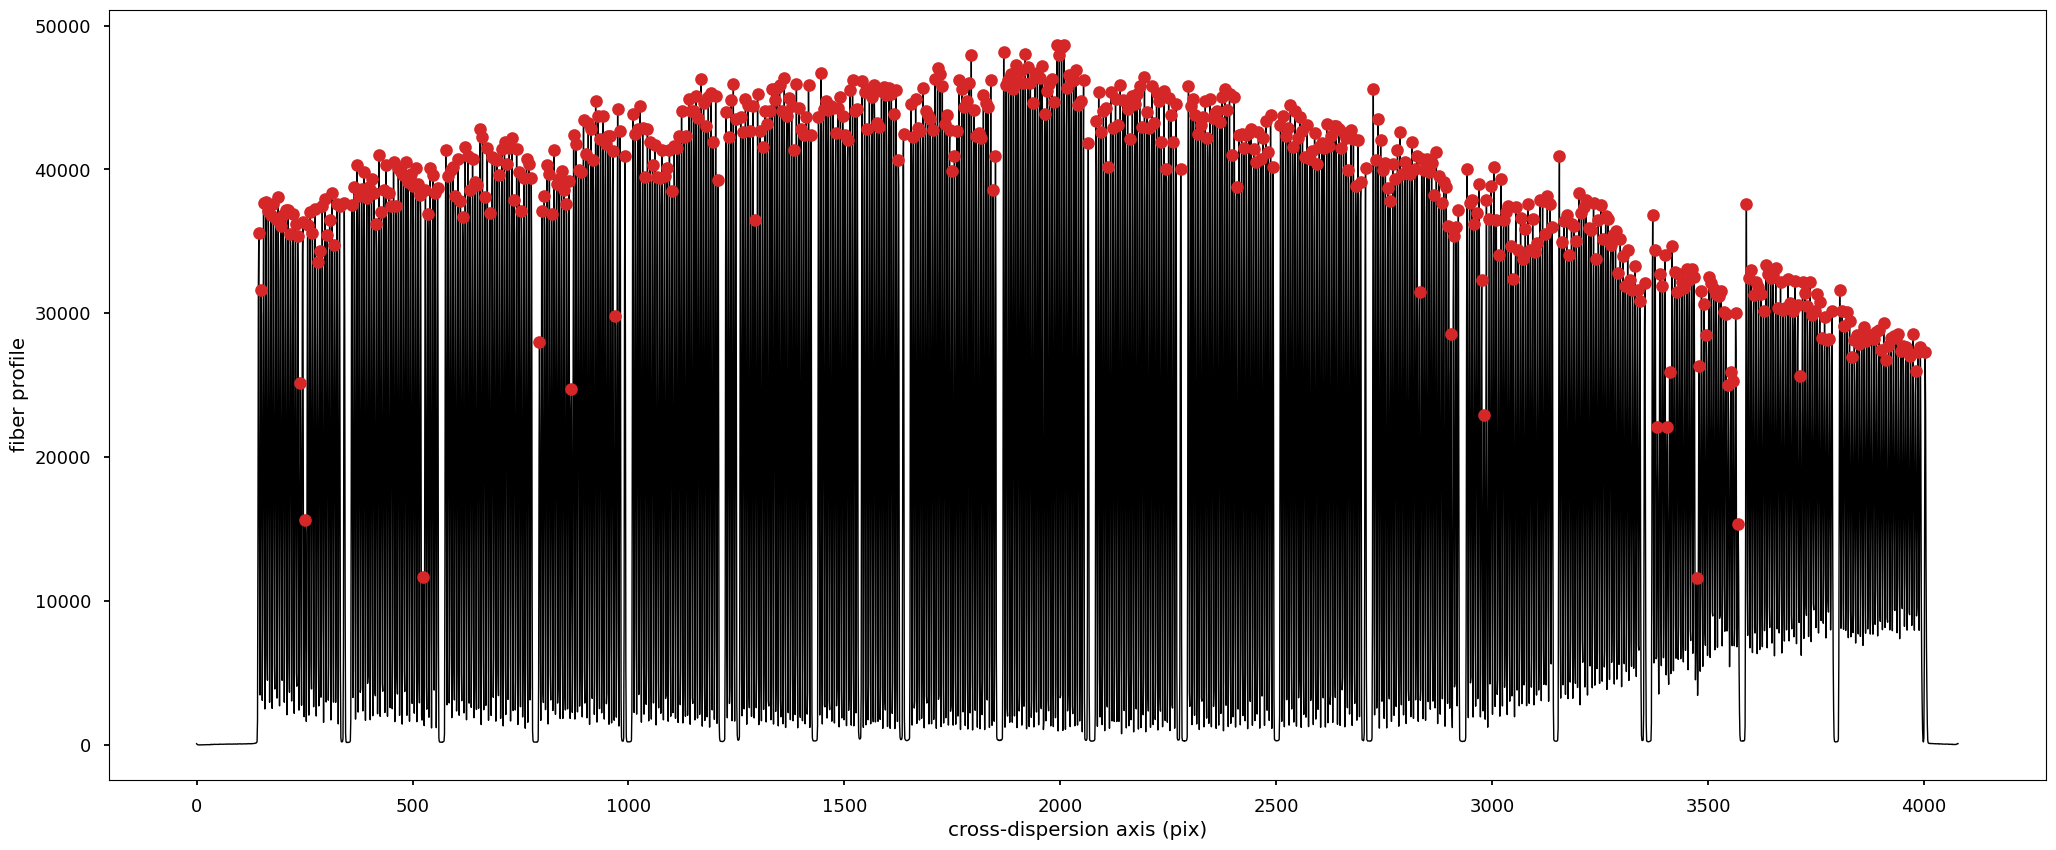

[INFO]: tracing fibers along dispersion axis


tracing fiber right from pixel 1870: 100%|###########################################################| 221/221 [00:45<00:00,  4.81pixel/s]


[INFO]: fitting trace with 2-deg polynomial


In [38]:
fiberflat_camera = "r1"

imageMethod.findPeaksAuto_drp(
            in_image=os.path.join(output_path, f"lvm-cfiberflat-{fiberflat_camera}-{fiberflat_expnum}.fits"),
            out_peaks=os.path.join(output_path, f"lvm-peaks-{fiberflat_camera}-{fiberflat_expnum}.txt"),
            nfibers=0, slice=1870, threshold=1000, method="gauss", median_box=5, median_cross=1, plot=1
        )
imageMethod.tracePeaks_drp(
        in_image=os.path.join(output_path, f"lvm-cfiberflat-{fiberflat_camera}-{fiberflat_expnum}.fits"),
        out_trace=os.path.join(output_path, f"lvm-trace-{fiberflat_camera}-{fiberflat_expnum}.fits"),
        in_peaks=os.path.join(output_path, f"lvm-peaks-{fiberflat_camera}-{fiberflat_expnum}.txt"),
        steps=10, coadd=30, threshold_peak=1000, max_diff=2, method="gauss", median_box=5, median_cross=1, plot=True,
        poly_disp=2
    )

[INFO]: selecting column = 1870 to locate fibers
[INFO]: locating fibers
[INFO]: found 638 fibers
[INFO]: refining fiber location
[INFO]: final number of fibers found 638


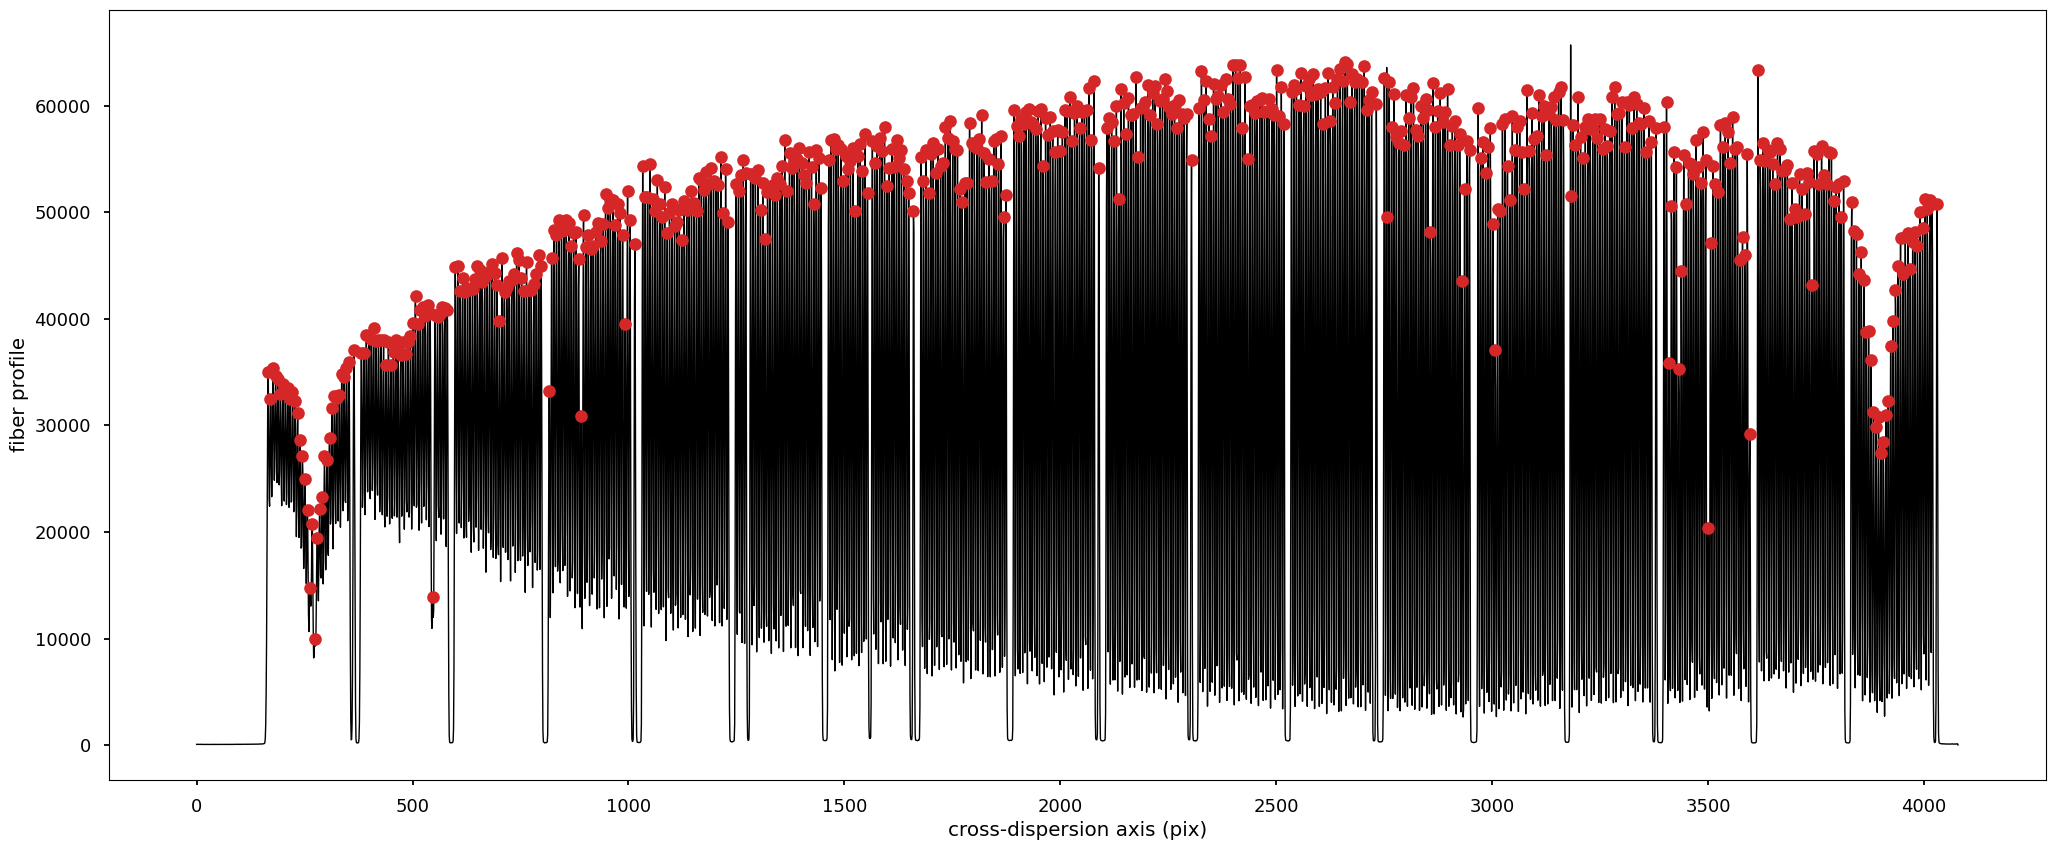

[INFO]: tracing fibers along dispersion axis


tracing fiber right from pixel 1870:  40%|#######################8                                    | 88/221 [00:24<00:37,  3.56pixel/s]

[WARNING]: Number of calls to function has reached maxfev = 9999. (RuntimeWarning)


tracing fiber right from pixel 1870: 100%|###########################################################| 221/221 [01:26<00:00,  2.57pixel/s]


[INFO]: fitting trace with 2-deg polynomial


In [39]:
fiberflat_camera = "z1"

imageMethod.findPeaksAuto_drp(
            in_image=os.path.join(output_path, f"lvm-cfiberflat-{fiberflat_camera}-{fiberflat_expnum}.fits"),
            out_peaks=os.path.join(output_path, f"lvm-peaks-{fiberflat_camera}-{fiberflat_expnum}.txt"),
            nfibers=0, slice=1870, threshold=1000, method="gauss", median_box=5, median_cross=1, plot=1
        )
imageMethod.tracePeaks_drp(
        in_image=os.path.join(output_path, f"lvm-cfiberflat-{fiberflat_camera}-{fiberflat_expnum}.fits"),
        out_trace=os.path.join(output_path, f"lvm-trace-{fiberflat_camera}-{fiberflat_expnum}.fits"),
        in_peaks=os.path.join(output_path, f"lvm-peaks-{fiberflat_camera}-{fiberflat_expnum}.txt"),
        steps=10, coadd=30, threshold_peak=1000, max_diff=2, method="gauss", median_box=5, median_cross=1, plot=True,
        poly_disp=2
    )

In [40]:
CHANNEL_WL = {"b1": (3600, 5930), "r1": (5660, 7720), "z1": (7470, 9800)}

ised = 319
coad = 5

for fiberflat_frame, arc_frame in zip(fiberflats, arcs):
    fiberflat_path = fiberflat_frame["path"]
    fiberflat_camera, fiberflat_expnum = fiberflat_frame["camera"], fiberflat_frame["expnum"]
    arc_path = arc_frame["path"]
    arc_camera, arc_expnum = arc_frame["camera"], arc_frame["expnum"]
    
    if arc_camera == "b1": continue
    
    wave_range = CHANNEL_WL[arc_camera]

    imageMethod.extractSpec_drp(
        in_image=out_main_path.format(kind="carc", camera=arc_camera, expnum=arc_expnum, ext="fits"),
        out_rss=out_main_path.format(kind="xarc", camera=arc_camera, expnum=arc_expnum, ext="fits"),
        in_trace=out_main_path.format(kind="trace", camera=fiberflat_camera, expnum=fiberflat_expnum, ext="fits"),
        method="aperture", aperture=4, plot=1, parallel="auto"
    )

    rssMethod.detWaveSolution_drp(
        in_arc=out_main_path.format(kind="xarc", camera=arc_camera, expnum=arc_expnum, ext="fits"),
        out_wave=out_main_path.format(kind="wave", camera=arc_camera, expnum=arc_expnum, ext="fits"),
        out_lsf=out_main_path.format(kind="lsf", camera=arc_camera, expnum=arc_expnum, ext="fits"),
        in_ref_lines=f"../../python/lvmdrp/etc/lvm-neon_nist_{arc_camera}.txt",
        ref_fiber=ised, poly_dispersion=5, poly_fwhm='3,1', aperture=13, plot=1
    )

    rssMethod.createPixTable_drp(
        in_rss=out_main_path.format(kind="xarc", camera=arc_camera, expnum=arc_expnum, ext="fits"),
        out_rss=out_main_path.format(kind="warc", camera=arc_camera, expnum=arc_expnum, ext="fits"),
        arc_wave=out_main_path.format(kind="wave", camera=arc_camera, expnum=arc_expnum, ext="fits"),
        arc_fwhm=out_main_path.format(kind="lsf", camera=arc_camera, expnum=arc_expnum, ext="fits")
    )
    
    rssMethod.resampleWave_drp(
        in_rss=out_main_path.format(kind="warc", camera=arc_camera, expnum=arc_expnum, ext="fits"),
        out_rss=out_main_path.format(kind="harc", camera=arc_camera, expnum=arc_expnum, ext="fits"),
        start_wave=wave_range[0], end_wave=wave_range[1], disp_pix=1.0, method="linear",
        err_sim=10, parallel="auto", extrapolate=True
    )

[INFO]: reading guess lines from '../../python/lvmdrp/etc/lvm-neon_nist_r1.txt'
[INFO]: going to use fiber 319 as reference
[INFO]: number of guess lines in file 27 percentage masked  7.40741 %
[INFO]: going to use 25 guess lines
[INFO]: reading arc from './data/lvm-xarc-r1-00000250.fits'
[INFO]: calculating shift in guess lines using CC
[INFO]: maximum CC shift = 2 pix
[INFO]: measuring arc lines for each fiber from ref_fiber = 319, flux_min = 200.0, fwhm_max = 10.0 and rel_flux_limits = [0.1, 5.0]


measuring arc lines upwards from ref_fiber = 319: 100%|##############################################| 319/319 [00:04<00:00, 66.08fiber/s]
measuring arc lines downwards from ref_fiber = 319: 100%|############################################| 318/318 [00:05<00:00, 61.84fiber/s]


[INFO]: smoothing FWHM of guess lines along cross-dispersion axis using 2-deg polynomials
[INFO]: fitting wavelength solutions using 5-deg polynomials
[WARNING]: fiber 34 has all lines masked
[WARNING]: fiber 69 has all lines masked
[WARNING]: fiber 70 has all lines masked
[WARNING]: fiber 106 has all lines masked
[WARNING]: fiber 141 has all lines masked
[WARNING]: fiber 177 has all lines masked
[WARNING]: fiber 212 has all lines masked
[WARNING]: fiber 246 has all lines masked
[WARNING]: fiber 282 has all lines masked
[WARNING]: fiber 317 has all lines masked
[WARNING]: fiber 352 has all lines masked
[WARNING]: fiber 388 has all lines masked
[WARNING]: fiber 423 has all lines masked
[WARNING]: fiber 459 has all lines masked
[WARNING]: fiber 495 has all lines masked
[WARNING]: fiber 530 has all lines masked
[WARNING]: fiber 601 has all lines masked
[WARNING]: fiber 602 has all lines masked
[WARNING]: fiber 637 has all lines masked
[INFO]: finished wavelength fitting with median RMS = 

measuring arc lines upwards from ref_fiber = 319: 100%|##############################################| 319/319 [00:04<00:00, 72.51fiber/s]
measuring arc lines downwards from ref_fiber = 319: 100%|############################################| 318/318 [00:04<00:00, 71.98fiber/s]


[INFO]: smoothing FWHM of guess lines along cross-dispersion axis using 2-deg polynomials
[INFO]: fitting wavelength solutions using 5-deg polynomials
[WARNING]: fiber 69 has all lines masked
[WARNING]: fiber 70 has all lines masked
[WARNING]: fiber 106 has all lines masked
[WARNING]: fiber 141 has all lines masked
[WARNING]: fiber 177 has all lines masked
[WARNING]: fiber 212 has all lines masked
[WARNING]: fiber 246 has all lines masked
[WARNING]: fiber 282 has all lines masked
[WARNING]: fiber 317 has all lines masked
[WARNING]: fiber 352 has all lines masked
[WARNING]: fiber 388 has all lines masked
[WARNING]: fiber 423 has all lines masked
[WARNING]: fiber 459 has all lines masked
[WARNING]: fiber 495 has all lines masked
[WARNING]: fiber 530 has all lines masked
[WARNING]: fiber 601 has all lines masked
[WARNING]: fiber 602 has all lines masked
[WARNING]: fiber 637 has all lines masked
[INFO]: finished wavelength fitting with median RMS = 0.0299775 AA
[INFO]: fitting LSF solution

Text(0.5, 1.0, "camera = 'z1'")

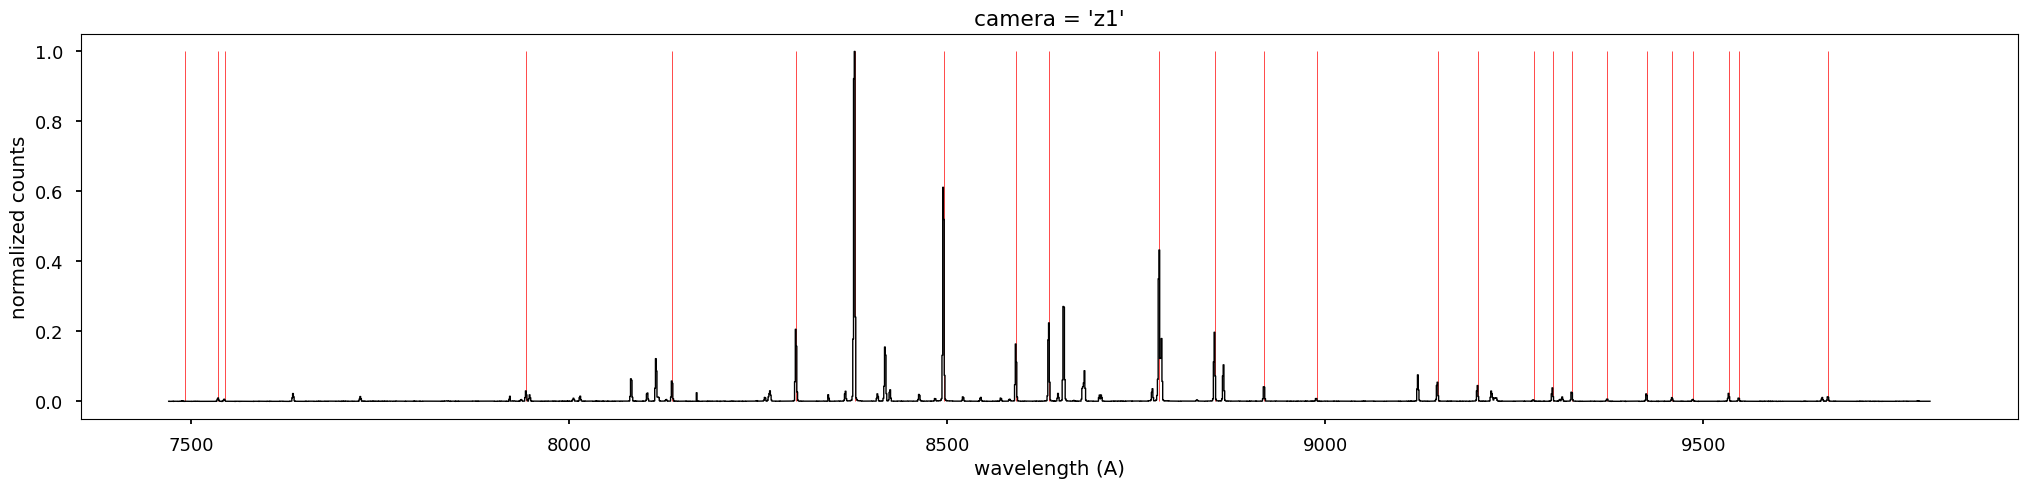

In [41]:
camera = "z1"

harc = rss.RSS()
harc.loadFitsData(out_main_path.format(kind="harc", camera=camera, expnum=arc_expnum, ext="fits"))

# with open(out_main_path.format(kind="pixwave", camera=camera, expnum=arc_expnum, ext="txt")) as f:
with open(f"../../python/lvmdrp/etc/lvm-neon_nist_{camera}.txt") as f:
    f.readline()
    lines_wav = []
    for line in f.readlines():
        _, line_wav, _ = line[:-1].split()
        lines_wav.append(float(line_wav))
    lines_wav = np.asarray(lines_wav)
    lines_int = np.ones_like(lines_wav)
    lines_min = np.zeros_like(lines_wav)

plt.figure(figsize=(25,5))
plt.vlines(lines_wav, lines_min, lines_int / lines_int, lw=0.5, ls="-", color="r")
plt.step(harc._wave, harc._data[ised]/np.nanmax(harc._data[ised]), color="k", lw=1)
plt.xlabel("wavelength (A)")
plt.ylabel("normalized counts")
plt.title(f"{camera = }")
# plt.gca().set_yscale("log")

In [42]:
for fiberflat_frame, arc_frame in zip(fiberflats, arcs):
    fiberflat_path = fiberflat_frame["path"]
    fiberflat_camera, fiberflat_expnum = fiberflat_frame["camera"], fiberflat_frame["expnum"]
    arc_path = arc_frame["path"]
    arc_camera, arc_expnum = arc_frame["camera"], arc_frame["expnum"]
    
    if arc_camera == "b1": continue
    
    wave_range = CHANNEL_WL[arc_camera]

    imageMethod.extractSpec_drp(
        in_image=out_main_path.format(kind="cfiberflat", camera=fiberflat_camera, expnum=fiberflat_expnum, ext="fits"),
        out_rss=out_main_path.format(kind="xfiberflat", camera=fiberflat_camera, expnum=fiberflat_expnum, ext="fits"),
        in_trace=out_main_path.format(kind="trace", camera=fiberflat_camera, expnum=fiberflat_expnum, ext="fits"),
        method="aperture", aperture=4, plot=1, parallel="auto"
    )
    
    rssMethod.createPixTable_drp(
        in_rss=out_main_path.format(kind="xfiberflat", camera=fiberflat_camera, expnum=fiberflat_expnum, ext="fits"),
        out_rss=out_main_path.format(kind="wfiberflat", camera=fiberflat_camera, expnum=fiberflat_expnum, ext="fits"),
        arc_wave=out_main_path.format(kind="wave", camera=arc_camera, expnum=arc_expnum, ext="fits"),
        arc_fwhm=out_main_path.format(kind="lsf", camera=arc_camera, expnum=arc_expnum, ext="fits")
    )
    
    rssMethod.resampleWave_drp(
        in_rss=out_main_path.format(kind="wfiberflat", camera=fiberflat_camera, expnum=fiberflat_expnum, ext="fits"),
        out_rss=out_main_path.format(kind="hfiberflat", camera=fiberflat_camera, expnum=fiberflat_expnum, ext="fits"),
        start_wave=wave_range[0], end_wave=wave_range[1], disp_pix=1.0, method="linear",
        err_sim=10, parallel="auto", extrapolate=True
    )

Text(0, 0.5, 'counts (e-/pix)')

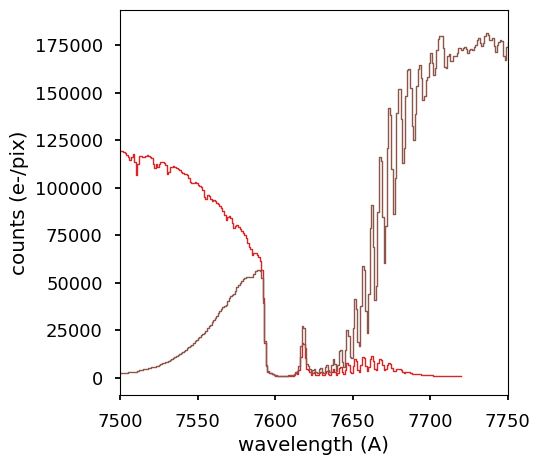

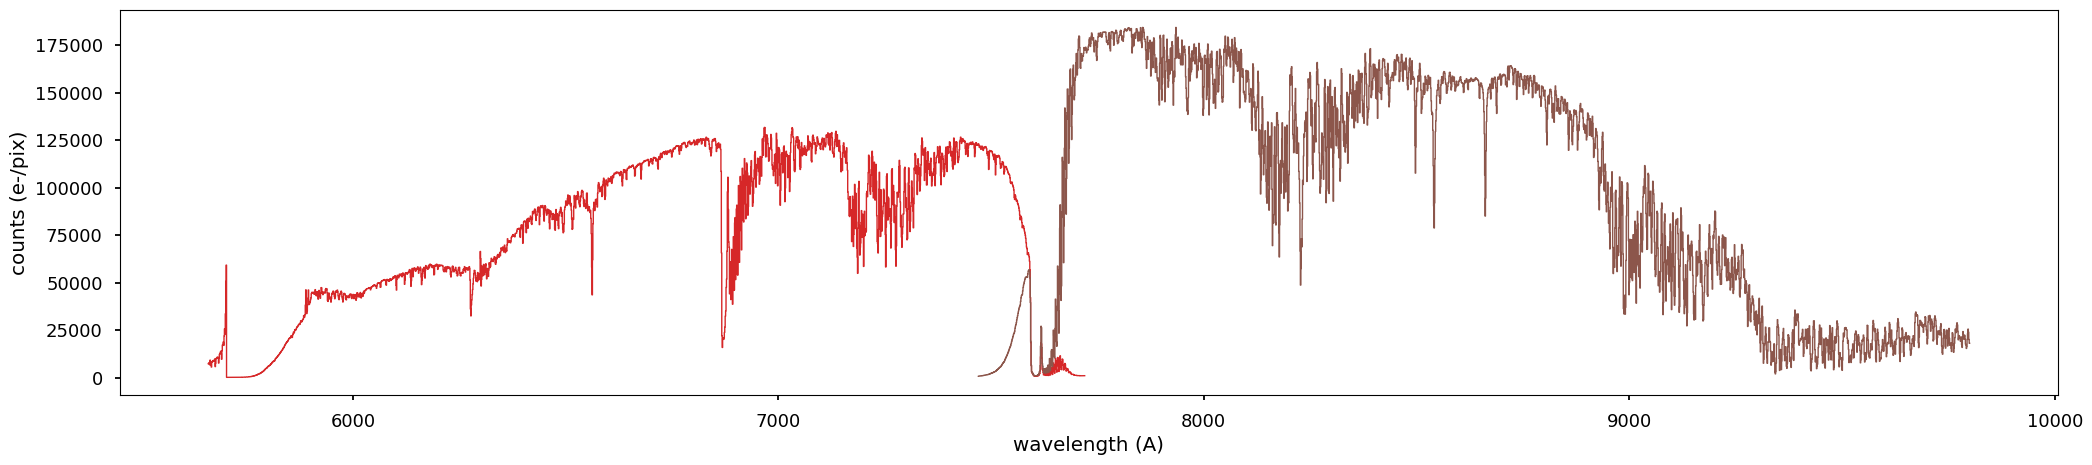

In [43]:
twilight_r = rss.RSS()
twilight_r.loadFitsData(out_main_path.format(kind="hfiberflat", camera="r1", expnum=fiberflat_expnum, ext="fits"))
superflat_r = twilight_r.create1DSpec()

twilight_z = rss.RSS()
twilight_z.loadFitsData(out_main_path.format(kind="hfiberflat", camera="z1", expnum=fiberflat_expnum, ext="fits"))
superflat_z = twilight_z.create1DSpec()

plt.figure(figsize=(5,5))
plt.step(superflat_r._wave, superflat_r._data, color="tab:red", lw=1)
plt.step(superflat_z._wave, superflat_z._data, color="tab:brown", lw=1)
plt.xlim(7500,7750)
plt.xlabel("wavelength (A)")
plt.ylabel("counts (e-/pix)")

plt.figure(figsize=(25,5))
plt.step(superflat_r._wave, superflat_r._data, color="tab:red", lw=1)
plt.step(superflat_z._wave, superflat_z._data, color="tab:brown", lw=1)
plt.xlabel("wavelength (A)")
plt.ylabel("counts (e-/pix)")

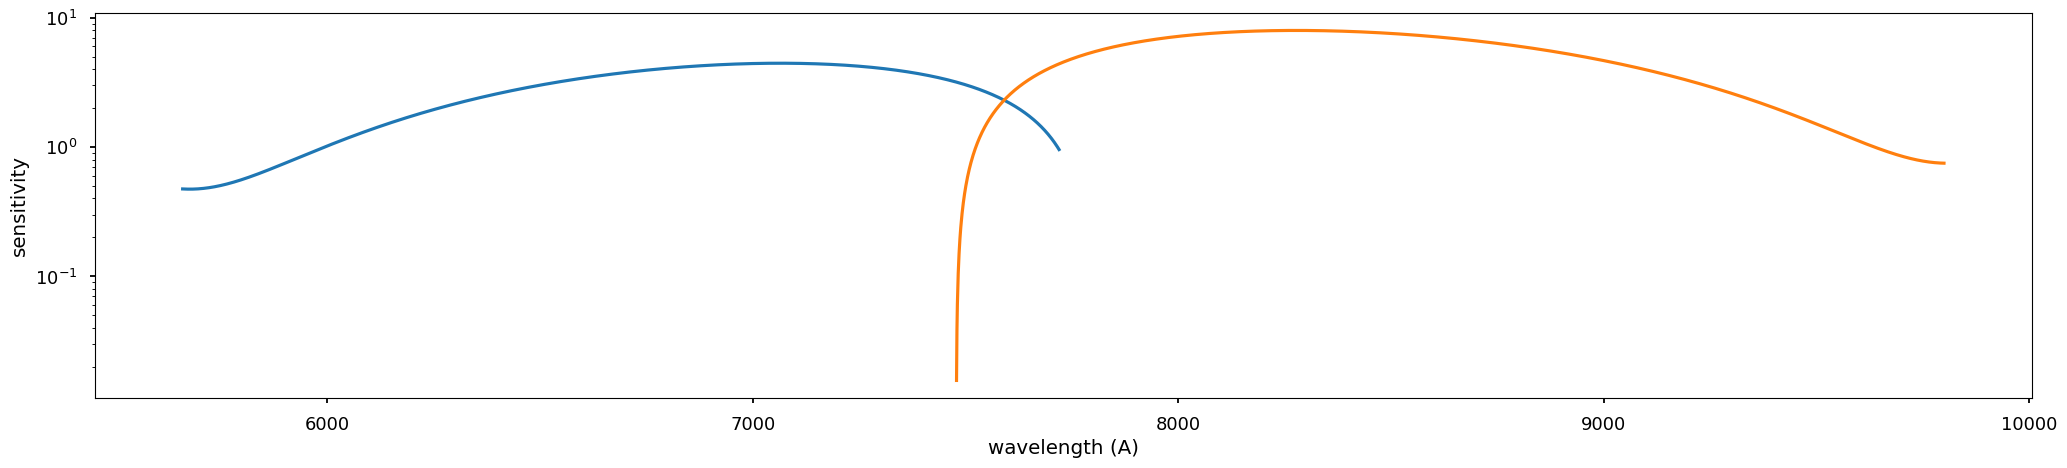

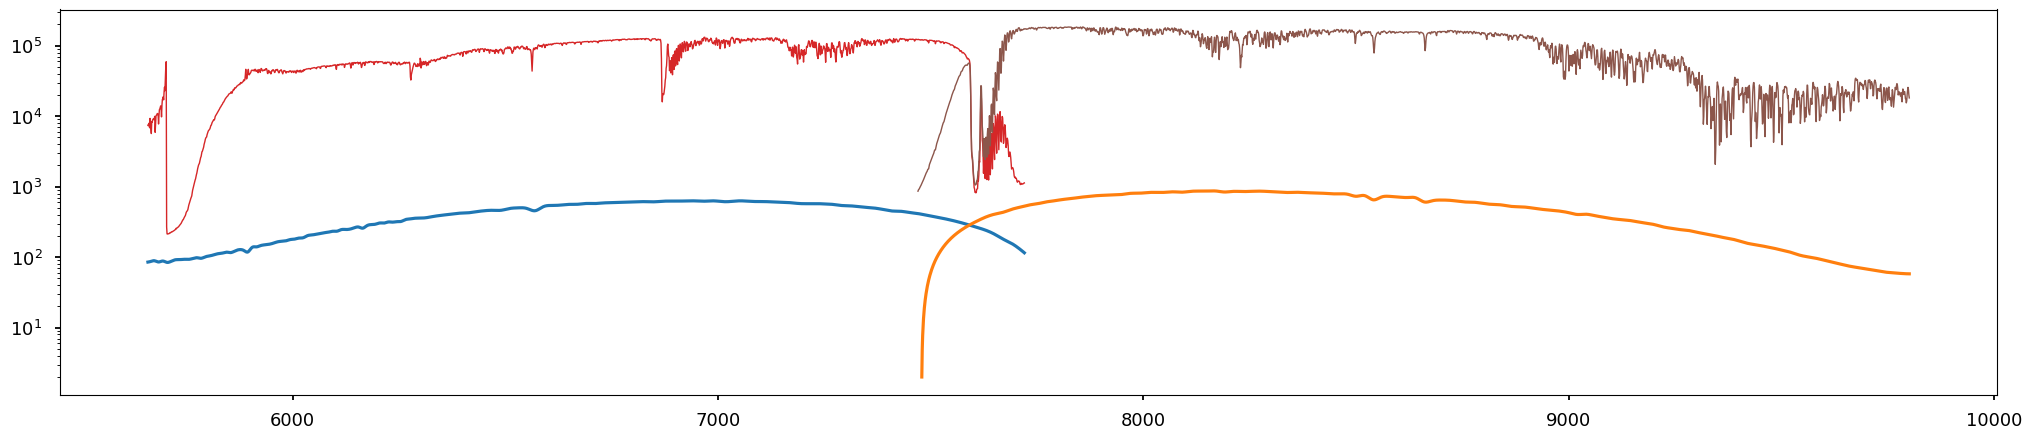

In [44]:
plt.figure(figsize=(25,5))
for camera in ["r1", "z1"]:
    fluxCalMethod.createSensFunction_drp(
        out_main_path.format(kind="hfiberflat", camera=camera, expnum=fiberflat_expnum, ext="fits"),
        out_main_path.format(kind="throughput", camera=camera, expnum=fiberflat_expnum, ext="fits"),
        extinct_curve="Paranal",
        ref_spec="../../python/lvmdrp/resources/sun.txt", column_wave=0, column_flux=1, header=0, ref_units=1,
        median_filt=0, smooth_poly=3,
        airmass=1.2,
        exptime=240,
        target_units=1,
        verbose=False
    )

    sens = spectrum1d.Spectrum1D()
    sens.loadFitsData(out_main_path.format(kind="throughput", camera=camera, expnum=fiberflat_expnum, ext="fits"))
    plt.semilogy(sens._wave[~sens._mask], 1/sens._data[~sens._mask])

plt.xlabel("wavelength (A)")
plt.ylabel("sensitivity")

sens_r = spectrum1d.Spectrum1D()
sens_r.loadFitsData(out_main_path.format(kind="throughput", camera="r1", expnum=fiberflat_expnum, ext="fits"))

sens_z = spectrum1d.Spectrum1D()
sens_z.loadFitsData(out_main_path.format(kind="throughput", camera="z1", expnum=fiberflat_expnum, ext="fits"))

sun = Sun.from_default()
sun_spec = spectrum1d.Spectrum1D(data=sun.fluxd.to("erg/(s cm2 AA)").value, wave=sun.wave.to("AA").value)
sun_r = sun_spec.resampleSpec(sens_r._wave)
sun_z = sun_spec.resampleSpec(sens_z._wave)

plt.figure(figsize=(25,5))
plt.semilogy(superflat_r._wave, superflat_r._data, color="tab:red", lw=1)
plt.semilogy(sens_r._wave[~sens_r._mask], (sun_r._data/sens_r._data)[~sens_r._mask])
plt.semilogy(superflat_z._wave, superflat_z._data, color="tab:brown", lw=1)
plt.semilogy(sens_z._wave[~sens_z._mask], (sun_z._data/sens_z._data)[~sens_z._mask])


In [45]:
objects = frames_groups[(unique_groups["imagetyp"]=="object")&(unique_groups["spec"]=="sp1")&(unique_groups["expnum"]=="00000207")]
objects.pprint(max_width=200)

for object_frame, fiberflat_frame, arc_frame in zip(objects, fiberflats, arcs):
    fiberflat_path = fiberflat_frame["path"]
    fiberflat_camera, fiberflat_expnum = fiberflat_frame["camera"], fiberflat_frame["expnum"]
    arc_path = arc_frame["path"]
    arc_camera, arc_expnum = arc_frame["camera"], arc_frame["expnum"]
    object_path = object_frame["path"]
    object_camera, object_expnum = object_frame["camera"], object_frame["expnum"]
    
    if arc_camera == "b1": continue
    
    wave_range = CHANNEL_WL[arc_camera]
    
    imageMethod.preprocRawFrame_drp(
        in_image=object_path,
        out_image=out_main_path.format(kind="pobject", camera=object_camera, expnum=object_expnum, ext="fits"),
        subtract_overscan=True, unit="electron", compute_error=True,
        os_bound_y="1,4080", os_bound_x="2044,2077",
        assume_imagetyp="object"
    )
    # imageMethod.LACosmic_drp(
    #     in_image=out_main_path.format(kind="pobject", camera=object_camera, expnum=object_expnum, ext="fits"),
    #     out_image=out_main_path.format(kind="robject", camera=object_camera, expnum=object_expnum, ext="fits"),
    #     iter=3, increase_radius=1, flim=1.3, parallel="0"
    # )
    imageMethod.basicCalibration_drp(
        in_image=out_main_path.format(kind="pobject", camera=object_camera, expnum=object_expnum, ext="fits"),
        out_image=out_main_path.format(kind="cobject", camera=object_camera, expnum=object_expnum, ext="fits"),
        in_bias=out_calib_path.format(mjd=mjd, kind="mbias", camera=bias_camera, exptime=0, expnum=bias_expnum, ext="fits"),
        in_dark=out_calib_path.format(mjd=mjd, kind="mdark", camera=object_camera, exptime=300, ext="fits"),
        # in_pixelflat=mpixelflat_path.format(camera=arc_camera, ext="fits")
    )
    
    imageMethod.extractSpec_drp(
        in_image=out_main_path.format(kind="cobject", camera=object_camera, expnum=object_expnum, ext="fits"),
        out_rss=out_main_path.format(kind="xobject", camera=object_camera, expnum=object_expnum, ext="fits"),
        in_trace=out_main_path.format(kind="trace", camera=fiberflat_camera, expnum=fiberflat_expnum, ext="fits"),
        method="aperture", aperture=4, plot=1, parallel="auto"
    )
    
    rssMethod.createPixTable_drp(
        in_rss=out_main_path.format(kind="xobject", camera=object_camera, expnum=object_expnum, ext="fits"),
        out_rss=out_main_path.format(kind="wobject", camera=object_camera, expnum=object_expnum, ext="fits"),
        arc_wave=out_main_path.format(kind="wave", camera=arc_camera, expnum=arc_expnum, ext="fits"),
        arc_fwhm=out_main_path.format(kind="lsf", camera=arc_camera, expnum=arc_expnum, ext="fits")
    )
    
    rssMethod.resampleWave_drp(
        in_rss=out_main_path.format(kind="wobject", camera=object_camera, expnum=object_expnum, ext="fits"),
        out_rss=out_main_path.format(kind="hobject", camera=object_camera, expnum=object_expnum, ext="fits"),
        start_wave=wave_range[0], end_wave=wave_range[1], disp_pix=1.0, method="linear",
        err_sim=10, parallel="auto", extrapolate=True
    )

imagetyp spec  mjd  camera  expnum  exptime                                                                   path                                                                 
-------- ---- ----- ------ -------- ------- ---------------------------------------------------------------------------------------------------------------------------------------
  object  sp1 60011     b1 00000207   900.0 /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/data.sdss5.org/sas/sdsswork/data/lvm/lab/60011/sdR-s-b1-00000207.fits.gz
  object  sp1 60011     r1 00000207   900.0 /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/data.sdss5.org/sas/sdsswork/data/lvm/lab/60011/sdR-s-r1-00000207.fits.gz
  object  sp1 60011     z1 00000207   900.0 /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/data.sdss5.org/sas/sdsswork/data/lvm/lab/60011/sdR-s-z1-00000207.fits.gz
[INFO]: using given overscan region Y = ['1', '4080'], X = ['2044', '2077']
[WARNING]: assuming 'TRI

Text(0.5, 1.0, "object_expnum = '00000207'")

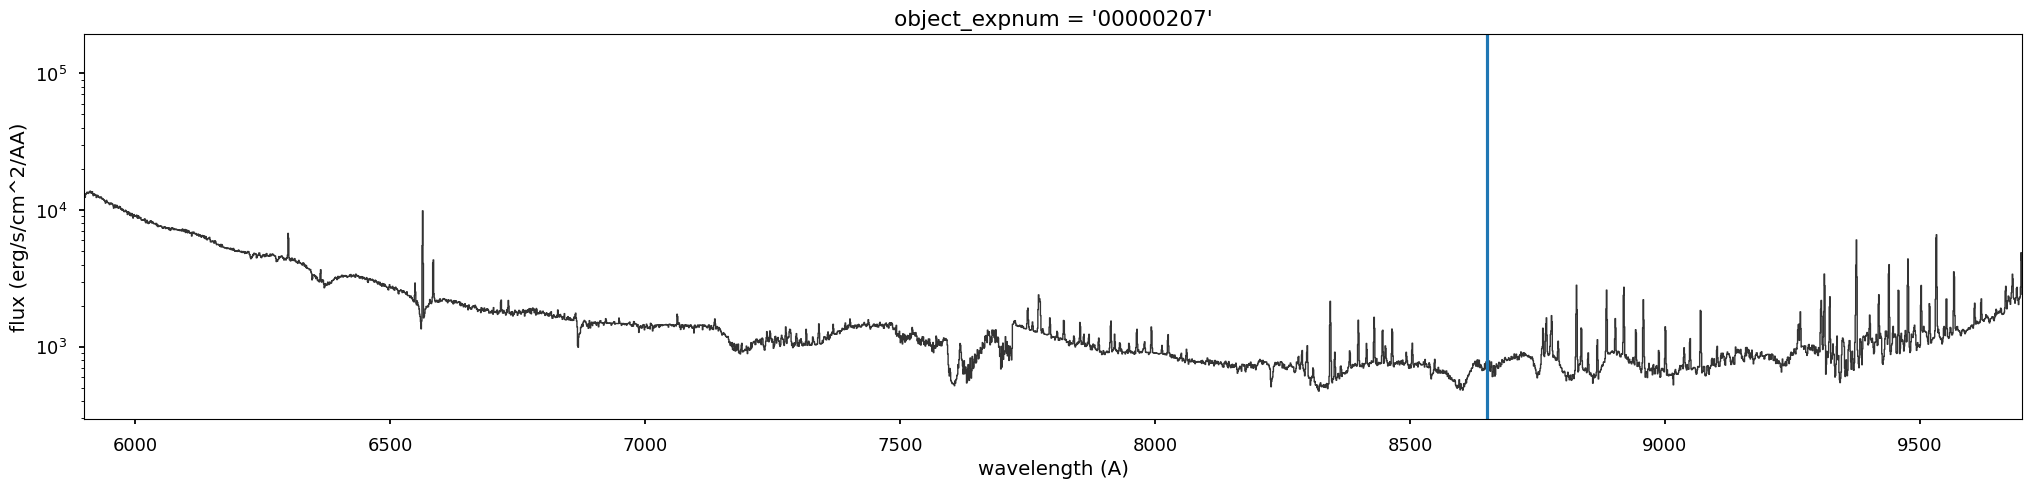

In [46]:
object_r = rss.RSS()
object_r.loadFitsData(out_main_path.format(kind="hobject", camera="r1", expnum=object_expnum, ext="fits"))
superobject_r = object_r.create1DSpec()
superobject_r._inst_fwhm = superobject_r._inst_fwhm.mean(axis=0)

object_z = rss.RSS()
object_z.loadFitsData(out_main_path.format(kind="hobject", camera="z1", expnum=object_expnum, ext="fits"))
superobject_z = object_z.create1DSpec()
superobject_z._inst_fwhm = superobject_z._inst_fwhm.mean(axis=0)

sens_r = spectrum1d.Spectrum1D()
sens_r.loadFitsData(out_main_path.format(kind="throughput", camera="r1", expnum=fiberflat_expnum, ext="fits"))
sens_z = spectrum1d.Spectrum1D()
sens_z.loadFitsData(out_main_path.format(kind="throughput", camera="z1", expnum=fiberflat_expnum, ext="fits"))

superobject_r *= sens_r
superobject_z *= sens_z

superobject = superobject_r.coaddSpec(superobject_z)

plt.figure(figsize=(25,5))
# plt.step(superobject_r._wave, superobject_r._data, color="tab:red", lw=1)
# plt.step(superobject_z._wave, superobject_z._data, color="tab:brown", lw=1)
# plt.vlines(wave_lines, 0, 1e5, lw=1, color="tab:red")
plt.step(superobject._wave, superobject._data, color="0.2", lw=1)
plt.gca().set_yscale("log")
plt.axvline(8650)
# plt.ylim(-500, 3000)
plt.xlim(5900, 9700)
plt.xlabel("wavelength (A)")
plt.ylabel("flux (erg/s/cm^2/AA)")
plt.title(f"{object_expnum = }")

[WARNING]: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect. (UserWarning)


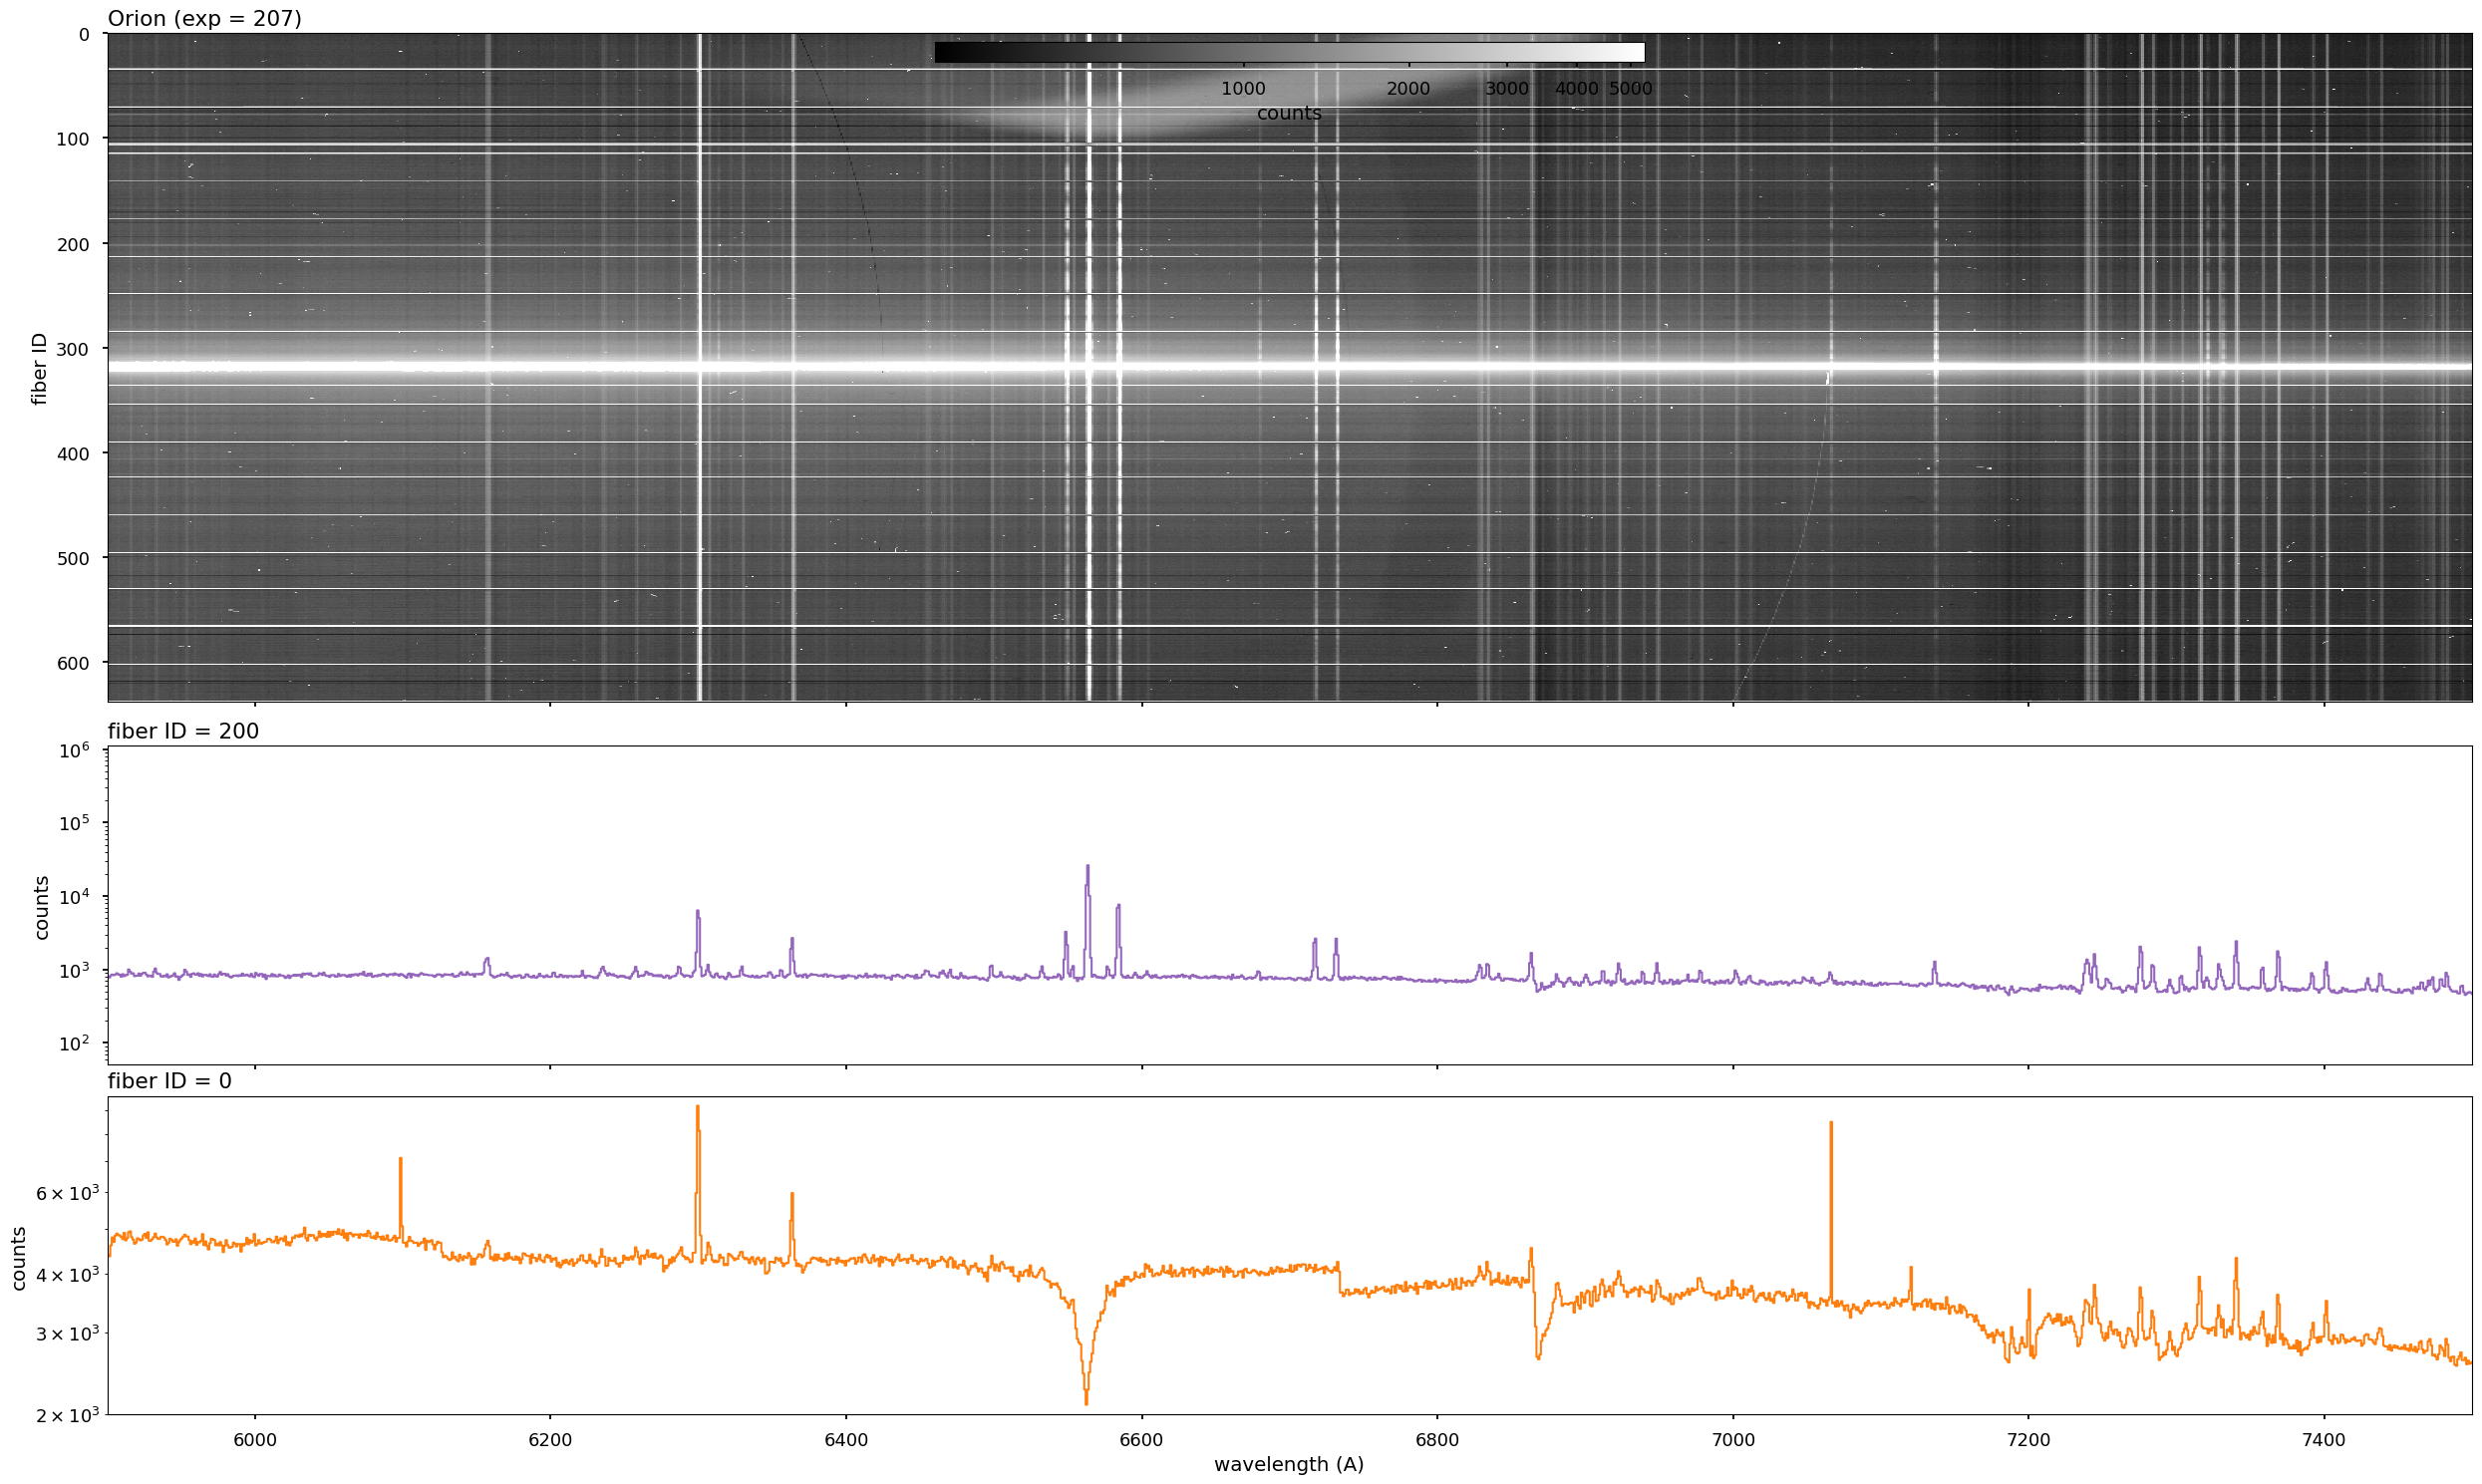

In [47]:
wave_lines, name_lines = np.loadtxt("../../../../lvm-dap/_fitting-data/_configs/MaNGA/emission_lines_long_list.MaNGA", dtype=str, unpack=True)
wave_lines = wave_lines.astype(float)

object_r = rss.RSS()
object_r.loadFitsData(out_main_path.format(kind="hobject", camera="r1", expnum="00000207", ext="fits"))

data = object_r._data
wave = object_r._wave

fiber_1 = 200
fiber_2 = 0
xmin, xmax = data.shape[0], 0
ymin, ymax = wave.min(), wave.max()

fig, (ax1, ax_neb) = plt.subplots(2, 1, figsize=(25,15), sharex=True, sharey=False)
ax1_divider = make_axes_locatable(ax_neb)
ax_ste = ax1_divider.append_axes("bottom", size="100%", pad="10%")
ax_ste.sharex(ax_neb)
ax_neb.tick_params(labelbottom=False)

norm = ImageNormalize(data, interval=PercentileInterval(95), stretch=AsinhStretch())
im1 = ax1.imshow(data, extent=(ymin,ymax,xmin,xmax), origin="lower", cmap=plt.cm.gray, norm=norm, interpolation="none", aspect="auto")

ax_neb.step(wave, data[fiber_1], color="tab:purple", lw=1.5)
ax_ste.step(wave, data[fiber_2], color="tab:orange", lw=1.5)

axins1 = inset_axes(ax1, width="30%", height="3%", loc="upper center")
axins1.xaxis.set_ticks_position("bottom")
cba = fig.colorbar(im1, cax=axins1, orientation="horizontal")

ax_neb.set_xlim(5900, 7500)
ax_ste.set_ylim(2e3, ax_ste.get_ylim()[1])
ax_ste.set_yscale("log")
ax_neb.set_yscale("log")

ax1.set_title("Orion (exp = 207)", loc="left")
ax_neb.set_title(f"fiber ID = {fiber_1}", loc="left")
ax_ste.set_title(f"fiber ID = {fiber_2}", loc="left")
ax1.set_ylabel("fiber ID")
ax_neb.set_ylabel("counts")
ax_ste.set_ylabel("counts")
ax_ste.set_xlabel("wavelength (A)")
cba.set_label("counts")
fig.tight_layout()